In [60]:
import pymc as pm
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import numpy as np

### Determine if a coin is biaised: Frequentist approach


**Null hypothesis**: the coin is not biaised, so it has a 0.5 probability of giving heads when tossed.

**Alternative hypothesis**: the coin is biased, the probability that it gives heads might be higher or lower than 50%.

---

**Spoiler alert**: it is biaised, 75% chance of heads, 25% of tails

### Conduct a Binomial test

Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html

`scipy.stats.binom_test(x, n=None, p=0.5, alternative='two-sided')`

---

#### Parameters:

1. x: int or array_like
The number of successes. 
> **_Here_** I use the number of tosses that gave HEADS, saved in the variable *successes*.

2. n: int
The number of trials. This is ignored if x gives both the number of successes and failures. 
> **_Here_** it is the *total_tosses*.

3. p: float, optional
The hypothesized probability of success. 0 <= p <= 1. The default value is p = 0.5. 
> **_Here_** my hypothesis is that the coin is not biaised, so I hypothesize that there is a 50% chance that the toss gives heads and a 50% that it gives tails.

4. alternative: {‘two-sided’, ‘greater’, ‘less’}, optional
Indicates the alternative hypothesis. The default value is ‘two-sided’.

> Two-tailed: if the estimated value is **greater or less than a certain range of values** (Wikipedia, One- and two-tailed tests).
Ex: a test taker may score below or above a given result.
Used for null hypothesis testing.

> One-tailed: appropriate if the estimated value may depart from the reference value in **only one direction**. 
Ex: if a machine can produce more than 1% of defective products.

> **_Here_**, as my coin could actually be biased towards both heads (so, it would have more than 0.5 probability of giving heads) or towards tails (less than 0.5 probability of giving heads), I chose the two-tailed or two-sided version.

---

#### Returns:
##### p-value: float 
The p-value of the hypothesis test.

In [127]:
# Determine your test arguments

## Number of trials
number_of_trials = 10

## Probability that the coin gives heads (we know that it is biased)
pi = 0.75 

# Create a list of n trials, where Heads is 1, tails is 0
tosses_list = random.choices([1, 0], [pi, 1 - pi], k=number_of_trials)

# total amount of tosses
total_tosses = len(tosses_list)

# Add the successes from the tosses_list
successes = sum(tosses_list)

In [128]:
# Print the result as a list
print(tosses_list)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


In [129]:
print(f"You got {successes} heads for {total_tosses} tosses.")

You got 9 heads for 10 tosses.


In [130]:
### Conduct the analysis
result = scipy.stats.binomtest(successes, n=total_tosses, p=0.5, alternative='two-sided')

In [131]:
### print the result 
print(result)

BinomTestResult(k=9, n=10, alternative='two-sided', statistic=0.9, pvalue=0.021484375)


In [132]:
### Give an indication about the result

chosen_alpha = 0.05

if result.pvalue > chosen_alpha:
    print(f"Your p-value is {result.pvalue}, which is greater than 0.05. \nYou cannot reject the null hypothesis.")
else:
    print(f"Your p-value is {result.pvalue}, which is less than 0.05. \nYou can reject the null hypothesis.")

Your p-value is 0.021484375, which is less than 0.05. 
You can reject the null hypothesis.


### Determine if a coin is biaised: Bayesian approach


**Hypothesis**: the coin is not biaised, so it has a 0.5 probability of giving heads when tossed.

---

**Spoiler alert**: it is biaised, 75% chance of heads, 25% of tails

In [133]:
# Define the data, here binary outcome of my observed data as the tosses_list

data = np.array([tosses_list])

#### Example 1

In [134]:
# define the probabilistic model: 
# here, estimate the probability of success (p) for a Bernoulli distribution

def bayesian_model(data, alpha=1, beta=1):
    """Estimates the probabbility of success for a Bernouilli distribution. Default: uninformed priors (alpha=1 and beta=1)."""
    with pm.Model() as model:
        p = pm.Beta('p', alpha, beta)
        y = pm.Bernoulli('y', p, observed=data)
        trace = pm.sample(1000, tune=1000)  # Perform MCMC sampling
        return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


<Axes: title={'center': 'p'}>

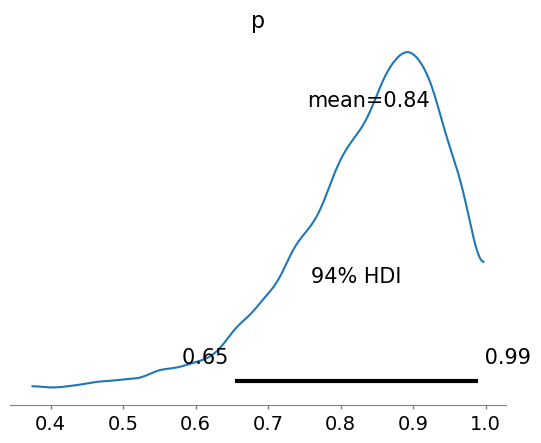

In [135]:
# Plot and analyse the result: uninformed prior

trace = bayesian_model(data)

pm.plot_posterior(trace, var_names=['p'])  # Plot posterior distribution of p

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


<Axes: title={'center': 'p'}>

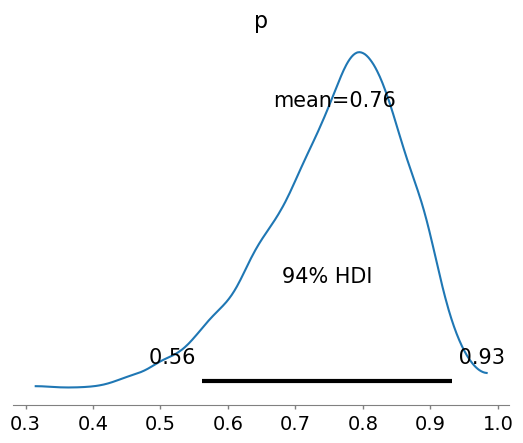

In [136]:
# Plot and analyse the result: weakly informed prior

trace = bayesian_model(data, alpha=3, beta=3)

pm.plot_posterior(trace, var_names=['p'])  # Plot posterior distribution of p

### A few notes on the Bayes factor

- Basic understanding: the Bayes factor is a measure of how the evidence (data collected, observed) support a model compared to another model (somehow an alternative to the significance measure)

- "it is a model comparison procedure" (Speekenbrink)

- in Bayesian hypothesis testing, we compare two models, a general model(G) and a more restricted model (R)

- the restricted model R is a special case of the general model G

> if BF of R, G = 12
> it means that the data that we observe is 12 times more likely to be observed under the restricted model R, compared to general model G
> this means that the evidence is strong for the restricted model
> our belief in model R is increase

____


### Credible intervals

- credible interval: "an interval in the posterior distribution which contains a given proportion of the probability mass"

- they indicate a portion of the probability æasss within which we think that the true value of a parameter lies

> Example of highest density interval:  a 95% HDI contains 95% of the probability mass
> it means that we think that the true value of a parameter is situated within these 95% 

### Understanding the beta distribution with scipy

- Beta distribution: a probability distribution

- Interval: [0, 1]

- Two positive parameters: alpha and beta

- Application: model the behavior of random variables with intervals of limited length

- Used as prior distribution for Bernoulli, binomial, negative binomial and geometric distribution

#### 1. The Beta Prior model

- a continuous prior probability model (pi): probability density function
- the PDF *f(pi)* specifies all the values of pi and the relative plausibility of each value (Bayes Rules, 3.1), NB: *f(pi)* is not a probability, but "can be used to compare the plausibility of two different values of pi" (bayes Rules, 3.1) (the greater *f(pi)*, the more plausible the value of pi)

#### 2. Proprieties of the beta probability model

- **Hyperparameter**: "a parameter used in a prior" (BR, 3.1.1)
- Hyperparameters of the Beta model: alpha and beta, with alpha > 0 and beta > 0
> pi ∼ Beta(aplha, beta)

- the Beta distribution can be "tuned" to best reflect your priors
- ex: if alpha = beta = 1, it is a uniform prior, flat, pi ∼ 

- **Measures of central tendency**: mean (average value of pi) and mode (most plausible value of pi)

- if alpha > beta : curve is right skewed
- if alpha < beta : curve left skewed
- if alpha = beta : curve symmetric (except uniform)

- **Variance**: "measures the typical *squared* distance of pi values from the mean", usually we use the standard deviation to avoid the squared units of the variance
- **standard deviation**: square root of the variance

#### 3. Tuning the beta prior

Michelle example: her average support is 45%, her highest score is 55% support. So, they chose alpha = 45 and beta = 55 (the curve will be left skewed)

- Trial and error process to obtain a distribution that looks like the obtained pools

- prior model for Michelle: pi ∼ Beta(45, 55)

- calculate the prior mean and the prior mode
- evaluate the prior standard deviation (square roots of the variance)

#### How do we define a prior and why do we define it this way?

- two extreme types of prior: certain and vague
- "the more **certain** the prior information, the *smaller* the prior variability"
- "the more **vague** the prior information, the *greater* the prior variability"
(Bayes Rules, 4.1)

- **Informative prior**: a prior which "reflects specific infirmation about the unknown variable with high certainty"

- **Vague prior**:"reflects little specific information of the unknowm variable"

> a special case of vague prior is the uniform prior distribution (Beta(alpha=1, beta=1) "assigns equal prior plausibility to each value or pi between 0 and 1"

In [142]:
# beta distribution
from scipy.stats import beta

x = np.linspace(0, 1, 100)
y = beta.pdf(x, 1, 1)

a = np.linspace(0, 1, 100)
b = beta.pdf(x, 5, 5)

e = np.linspace(0, 1, 100)
f = beta.pdf(x, 20, 20)

# pdf(x, a, b, loc=0, scale=1)

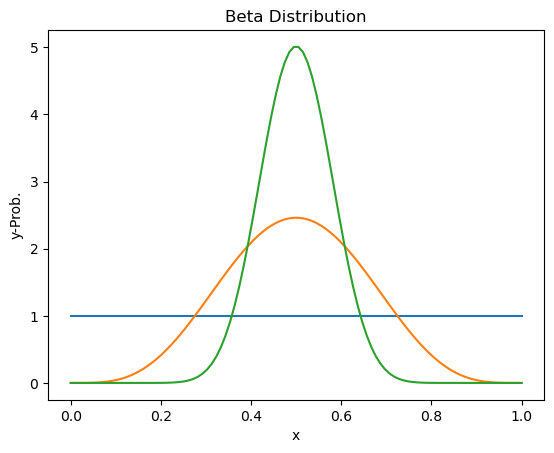

In [143]:
# plot

plt.plot(x, y)
plt.plot(a, b)
plt.plot(e, f)
plt.xlabel("x")
plt.ylabel("y-Prob.")
plt.title("Beta Distribution")
plt.show()

45